# Wikipedia Talk Data - Getting Started

This notebook gives an introduction to working with the various data sets in [Wikipedia
Talk](https://figshare.com/projects/Wikipedia_Talk/16731) project on Figshare. The release includes:

1. a large historical corpus of discussion comments on Wikipedia talk pages
2. a sample of over 100k comments with human labels for whether the comment contains a personal attack
3. a sample of over 100k comments with human labels for whether the comment has aggressive tone

Please refer to our [wiki](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release) for documentation of the schema of each data set and our [research paper](https://arxiv.org/abs/1610.08914) for documentation on the data collection and modeling methodology. 

In this notebook we show how to build a simple classifier for detecting personal attacks and apply the classifier to a random sample of the comment corpus to see whether discussions on user pages have more personal attacks than discussion on article pages.

## Building a classifier for personal attacks
In this section we will train a simple bag-of-words classifier for personal attacks using the [Wikipedia Talk Labels: Personal Attacks]() data set.

In [1]:
import pandas as pd
import urllib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [2]:
# download annotated comments and annotations

ANNOTATED_COMMENTS = 'https://ndownloader.figshare.com/files/7038044' 
ANNOTATIONS = 'https://ndownloader.figshare.com/files/7038047' 


def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

                
download_file(ANNOTATED_COMMENTS, 'attack_annotated_comments.tsv')
download_file(ANNOTATIONS, 'attack_annotations.tsv')

In [3]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [4]:
# labels a comment as an atack if the majority of annoatators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [5]:
# join labels and comments
comments['attack'] = labels

In [6]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [7]:
comments.query('attack')['comment'].head()

rev_id
801279             Iraq is not good  ===  ===  USA is bad   
2702703      ____ fuck off you little asshole. If you wan...
4632658         i have a dick, its bigger than yours! hahaha
6545332      == renault ==  you sad little bpy for drivin...
6545351      == renault ==  you sad little bo for driving...
Name: comment, dtype: object

In [8]:
# fit a simple text classifier

train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.957


In [9]:
# correctly classify nice comment
clf.predict(['Thanks for you contribution, you did a great job!'])

array([False], dtype=bool)

In [10]:
# correctly classify nasty comment
clf.predict(['People as stupid as you should not edit Wikipedia!'])

array([ True], dtype=bool)

## Prevalence of personal attacks by namespace
In this section we use our classifier in conjunction with the [Wikipedia Talk Corpus](https://figshare.com/articles/Wikipedia_Talk_Corpus/4264973) to see if personal attacks are more common on user talk or article talk page discussions. In our paper we show that the model is not biased by namespace.

In [11]:
import os
import re
from scipy.stats import bernoulli
% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# download and untar data

USER_TALK_CORPUS_2004 = 'https://ndownloader.figshare.com/files/6982061'
ARTICLE_TALK_CORPUS_2004 = 'https://ndownloader.figshare.com/files/7038050'

download_file(USER_TALK_CORPUS_2004, 'comments_user_2004.tar.gz')
download_file(ARTICLE_TALK_CORPUS_2004,  'comments_article_2004.tar.gz')

os.system('tar -xzf comments_user_2004.tar.gz')
os.system('tar -xzf comments_article_2004.tar.gz')

0

In [13]:
# helper for collecting a sample of comments for a given ns and year from 
def load_no_bot_no_admin(ns, year, prob = 0.1):
    
    dfs = []
    
    data_dir = "comments_%s_%d" % (ns, year)
    for _, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if re.match("chunk_\d*.tsv", filename):
                df = pd.read_csv(os.path.join(data_dir, filename), sep = "\t")
                df['include'] = bernoulli.rvs(prob, size=df.shape[0])
                df = df.query("bot == 0 and admin == 0 and include == 1")
                dfs.append(df)
                
    sample = pd.concat(dfs)
    sample['ns'] = ns
    sample['year'] = year
    
    return sample

In [14]:
# collect a random sample of comments from 2004 for each namespace
corpus_user = load_no_bot_no_admin('user', 2004)
corpus_article = load_no_bot_no_admin('article', 2004)
corpus = pd.concat([corpus_user, corpus_article])

In [15]:
# Apply model
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
corpus['attack'] = clf.predict_proba(corpus['comment'])[:,1] > 0.425 # see paper

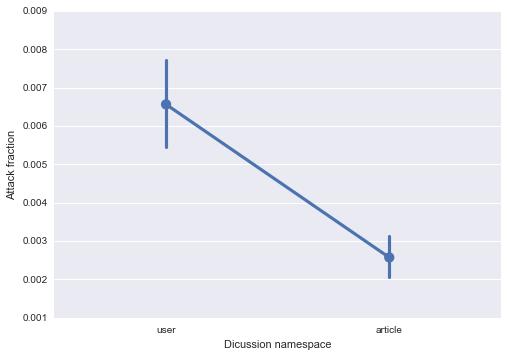

In [16]:
# plot prevalence per ns

sns.pointplot(data = corpus, x = 'ns', y = 'attack')
plt.ylabel("Attack fraction")
plt.xlabel("Dicussion namespace")

Attacks are far more prevalent in the user talk namespace.